In [1]:
#先看看文件里面都有什么,可视化一下结构
import h5py

GW='LDC2_spritz_mbhb1_training_v1.h5'

def print_structure(hdf5_object, indent=0):
    if isinstance(hdf5_object, h5py.Group):
        for key in hdf5_object:
            item = hdf5_object[key]
            print('  ' * indent + f'Group: {key}')
            print_structure(item, indent + 1)
    elif isinstance(hdf5_object, h5py.Dataset):
        print('  ' * indent + f'Dataset: {hdf5_object.name}')
        print('  ' * indent + f' - Shape: {hdf5_object.shape}, Type: {hdf5_object.dtype}')

#with h5py.File(GW, 'r') as file:
    #print_structure(file)   #确定长度535680=31*24*60*60/5
    
    #date = file['/header/date'][()] 
    #print('Date:', date)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from WDMWaveletTransforms.wavelet_transforms import inverse_wavelet_freq,inverse_wavelet_freq_time,inverse_wavelet_time,transform_wavelet_time,transform_wavelet_freq,transform_wavelet_freq_time
import matplotlib.colors as colors
#检查有没有NaN并换成0
def extract_data(tdi):
    time = tdi['t'] 
    x = tdi['X']    
    y = tdi['Y']    
    z = tdi['Z']    
    
    # 检查是否含有 NaN 并打印结果
    print("Contains NaN",  ":", np.isnan(x).any(), np.isnan(y).any(), np.isnan(z).any())
    
    # 将 NaN 替换为 0
    x = np.nan_to_num(x, nan=0)
    y = np.nan_to_num(y, nan=0)
    z = np.nan_to_num(z, nan=0)

    return time, x, y, z

#检查一下时间序列是否完全一样    
def check_time(time1, time2):
    print("Equal",  ":",np.array_equal(time1, time2))

def normalize(strain):
    std = np.std(strain[:])
    strain[:] /= std
    return strain

def plot_dataset(row, time, x, y, z, dataset_name):
    base_index = (row - 1) * 3 + 1
    
    plt.subplot(4, 3, base_index)
    plt.plot(time, x, label=f'{dataset_name} X')
    plt.title(f'{dataset_name} X')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

    plt.subplot(4, 3, base_index + 1)
    plt.plot(time, y, label=f'{dataset_name} Y')
    plt.title(f'{dataset_name} Y')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

    plt.subplot(4, 3, base_index + 2)
    plt.plot(time, z, label=f'{dataset_name} Z')
    plt.title(f'{dataset_name} Z')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()

with h5py.File(GW, 'r') as file:
    clean_tdi     = file['/clean/tdi'][:]
    noisefree_tdi = file['/noisefree/tdi'][:]
    obs_tdi       = file['/obs/tdi'][:]
    sky_tdi       = file['/sky/tdi'][:]

    clean_time, clean_x, clean_y, clean_z                 = extract_data(clean_tdi)     
    noisefree_time, noisefree_x, noisefree_y, noisefree_z = extract_data(noisefree_tdi)
    obs_time, obs_x, obs_y, obs_z                         = extract_data(obs_tdi)
    sky_time, sky_x, sky_y, sky_z                         = extract_data(sky_tdi)  
    print(np.isnan(noisefree_x).any())

    check_time(clean_time, noisefree_time)
    check_time(clean_time, obs_time)
    check_time(clean_time, sky_time)

Contains NaN : False False False
Contains NaN : True True True
Contains NaN : True True True
Contains NaN : False False False
False
Equal : True
Equal : True
Equal : True


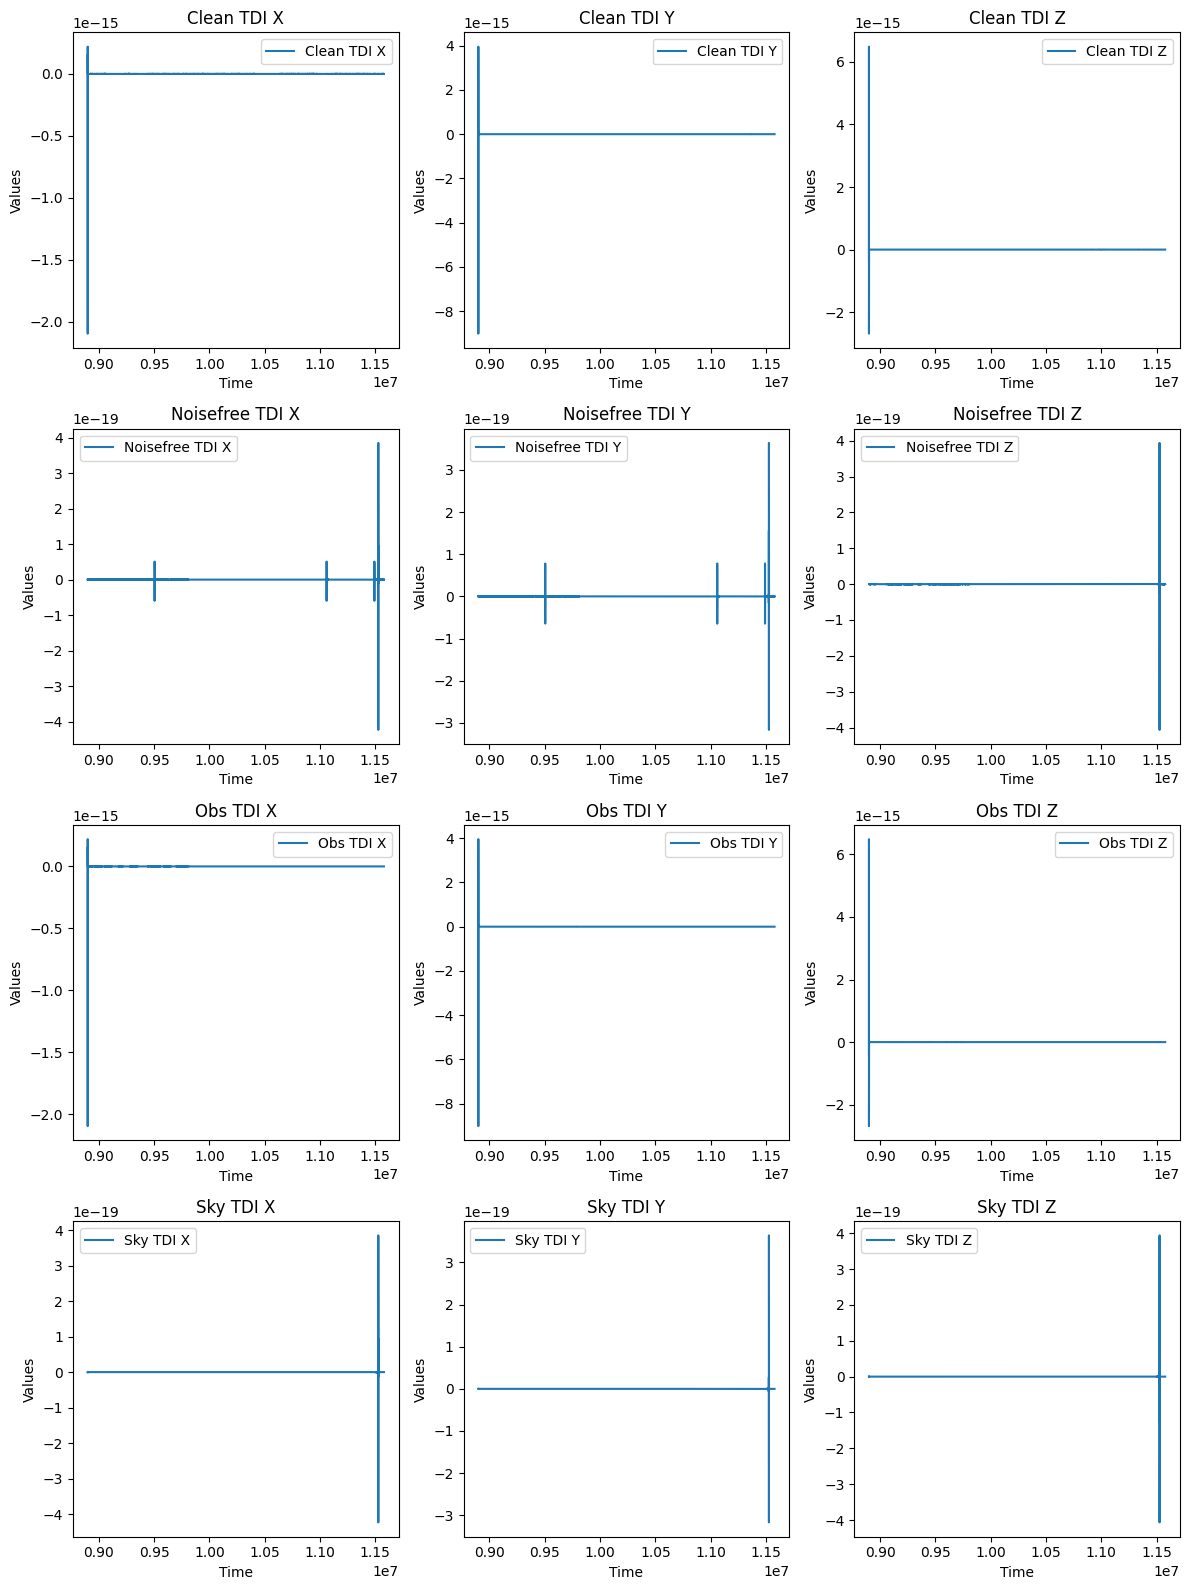

In [39]:
    #简单看看数据   
    plt.figure(figsize=(12, 16)) 
    plot_dataset(1, clean_time, clean_x, clean_y, clean_z, 'Clean TDI')
    plot_dataset(2, noisefree_time, noisefree_x, noisefree_y, noisefree_z, 'Noisefree TDI')
    plot_dataset(3, obs_time, obs_x, obs_y, obs_z, 'Obs TDI')
    plot_dataset(4, sky_time, sky_x, sky_y, sky_z, 'Sky TDI')

    plt.tight_layout()
    plt.show()

### 接下来用小波变换处理一下clean TDI的数据

Min value: 1.3703341238674434e-51
Max value: 2.0263375479855274e-31
Mean value: 9.438749683075618e-35
Standard deviation: 2.9087641191237745e-33


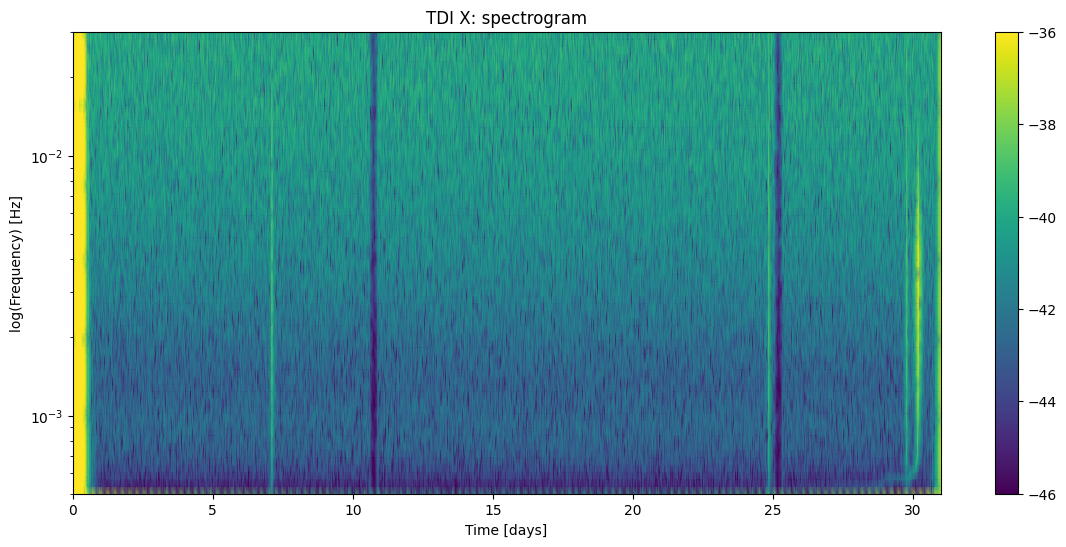

In [47]:
    signal_time_in=obs_x.reshape(-1) 
    
    Nt=1500        #调节小波变化的参数
    Nf=64
    dt=5

    padding = np.zeros(4000)        #添加扩展尽量减少边缘处的影响
    padded_signal = np.concatenate((padding, signal_time_in, padding))

    signal_wavelet_out = transform_wavelet_freq_time(padded_signal, Nf, Nt, dt).T
    power = np.abs(signal_wavelet_out)**2

    print("Min value:", np.min(power))
    print("Max value:", np.max(power))
    print("Standard deviation:", np.std(power))

    power_log = np.log10(power)  #标准差很小，所以选择用对数函数处理

    f_min = 0.0005  
    f_max = 0.03  
    frequencies = np.logspace(np.log10(f_min), np.log10(f_max), Nf)   #依照要求画对数坐标图
    
    tt=31/(Nt*dt)   #31天
    time = np.arange(0, tt* Nt * dt ,tt*dt) 

    # 创建颜色规范对象，这里使用对数规范，调到和要求的图差不多的范围
    norm = colors.Normalize(vmin=-46, vmax=-36)  

    plt.figure(figsize=(14, 6))
    c = plt.pcolormesh(time, frequencies, power_log, norm=norm, cmap='viridis', shading='gouraud')
    plt.colorbar(c)
    plt.yscale('log')
    plt.xlabel('Time [days]')
    plt.ylabel('log(Frequency) [Hz]')
    plt.title('TDI X: spectrogram')
    plt.show()
